In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

In [2]:
sitecoords = (28.21, -25.91, 1560) #(27.16, -26.61,1516)
nrays = 360  # number of rays
nbins = 801  # number of range bins
el = 0.5  # vertical antenna pointing angle (deg)
bw = 0.93  # half power beam width (deg)
range_res = 250.0 # range resolution (meters)

In [3]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [4]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(
    coord[..., 0], coord[..., 1], coord[..., 2], sitecoords
)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [5]:
polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (360, 801, 3)


In [6]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print(
    "Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f"
    % (lat.max(), lon.min(), lon.max(), lat.min())
)

Radar bounding box:
	-24.10
26.21             30.21
	-27.71


In [7]:
ds = wrl.io.open_raster('gt30e020s10.tif')
rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds, nodata=-32768)

In [8]:
rastervalues

array([[  1163,   1093,   1150, ..., -32768, -32768, -32768],
       [  1180,   1161,   1083, ..., -32768, -32768, -32768],
       [  1187,   1176,   1112, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

In [9]:
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3, prefilter=False
)

In [10]:
polcoords.shape

(360, 801, 2)

In [11]:
np.atleast_1d(polarvalues).shape

(360, 801)

In [12]:
beamradius.shape

(801,)

In [100]:
# Assuming 'array' is your (360, 801) array
barray = np.zeros((360, 801))  # Example initialization, replace this with your actual array

# Set all elements to 1000
barray[:, :] = 1700

In [101]:
elevation[-1,-1]

1445

In [102]:
# Placeholder for the result
coverage_points = []

elevation = np.atleast_1d(polarvalues)
beam_height = barray #np.atleast_1d(alt)
lat_lon = np.atleast_1d(polcoords)

for angle_idx in range(360):
    for range_idx in range(801):
        if elevation[angle_idx, range_idx] > beam_height[angle_idx, range_idx]:
            coverage_points.append(lat_lon[angle_idx, range_idx])
        else:
            coverage_points.append(lat_lon[angle_idx,-1])
            #break  # Move to the next angle after finding the first point

In [103]:
elevation[0,0]

1513

In [104]:
beam_height[0,0]

1700.0

In [105]:
coverage_points = np.array(coverage_points)

In [106]:
#coverage_points

In [107]:
from shapely.geometry import Polygon
import geopandas as gpd

# Create a polygon from the coordinates
polygon = Polygon(coverage_points)

In [108]:
df = gpd.GeoDataFrame(geometry=[polygon])

<Axes: >

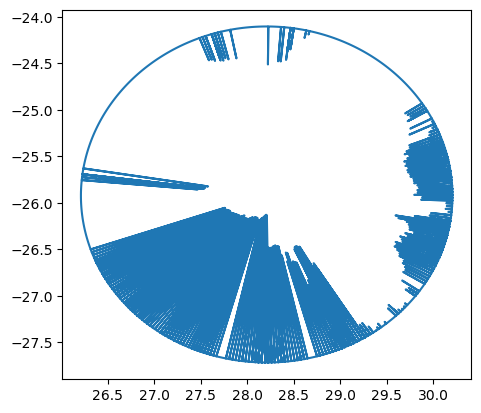

In [109]:
df.boundary.plot()

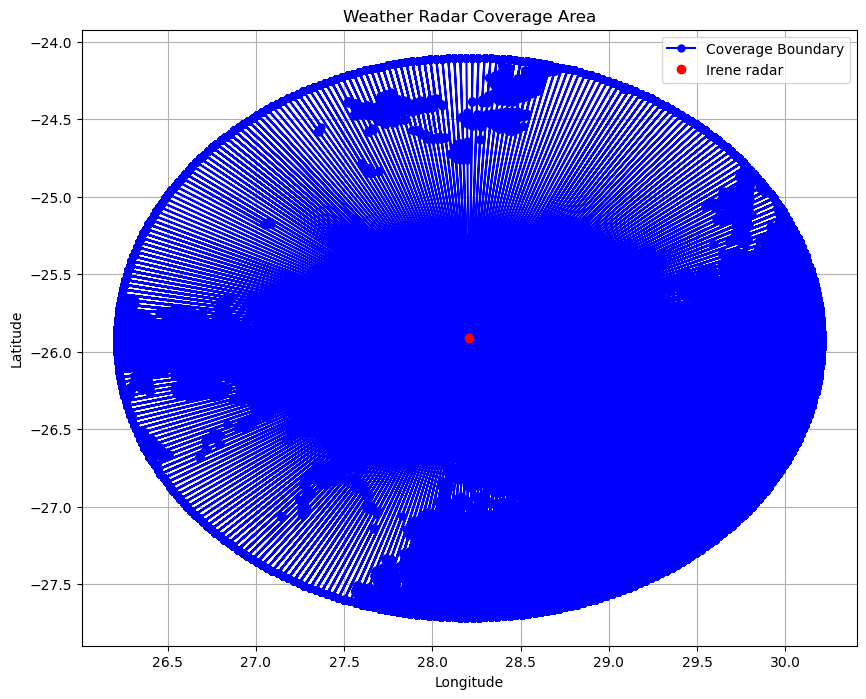

In [90]:
# Extract latitudes and longitudes
lats = coverage_points[:, 1]
lons = coverage_points[:, 0]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(lons, lats, 'bo-', markersize=5, label='Coverage Boundary')
plt.plot(sitecoords[0], sitecoords[1], "ro", label='Irene radar')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Weather Radar Coverage Area')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 801)


In [19]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 801)


In [20]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks() / 1000).astype(int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks() / 1000).astype(int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    #if not cm is None:
    #    plt.colorbar(cm, ax=ax)
    if not title == "":
        ax.set_title(title)
    ax.grid()

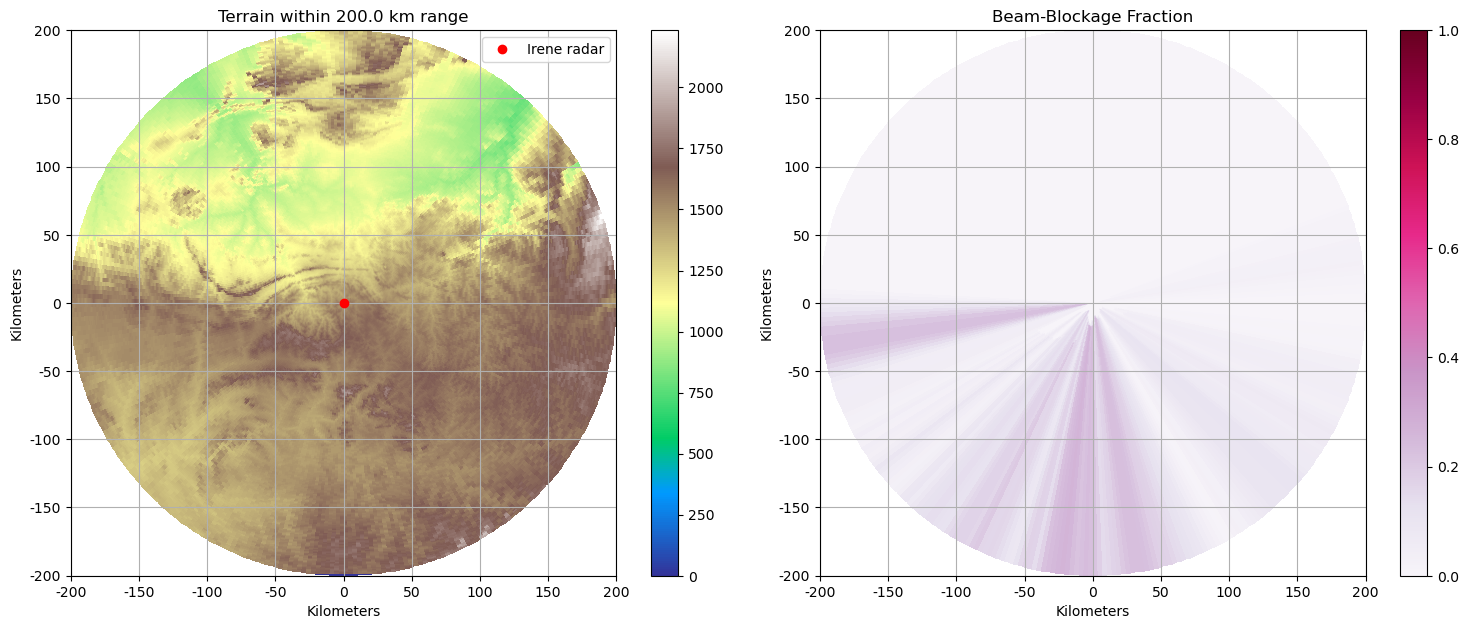

In [21]:
fig = plt.figure(figsize=(15, 12))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))

# azimuth angle
angle = 265

# Plot terrain (on ax1)
polarvalues = wrl.georef.create_xarray_dataarray(
    polarvalues, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
dem = polarvalues.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0)
#ax1.plot(
#    [0, np.sin(np.radians(angle)) * 2e5], [0, np.cos(np.radians(angle)) * 2e5], "r-"
#)
ax1.plot(sitecoords[0], sitecoords[1], "ro", label='Irene radar')

annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) ))

ax1.legend()

# Plot CBB (on ax2)
CBB = wrl.georef.create_xarray_dataarray(
    CBB, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
cbb = CBB.wrl.vis.plot(ax=ax2, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, "Beam-Blockage Fraction")

plt.tight_layout()
plt.savefig('coverage_map.png', dpi=400)

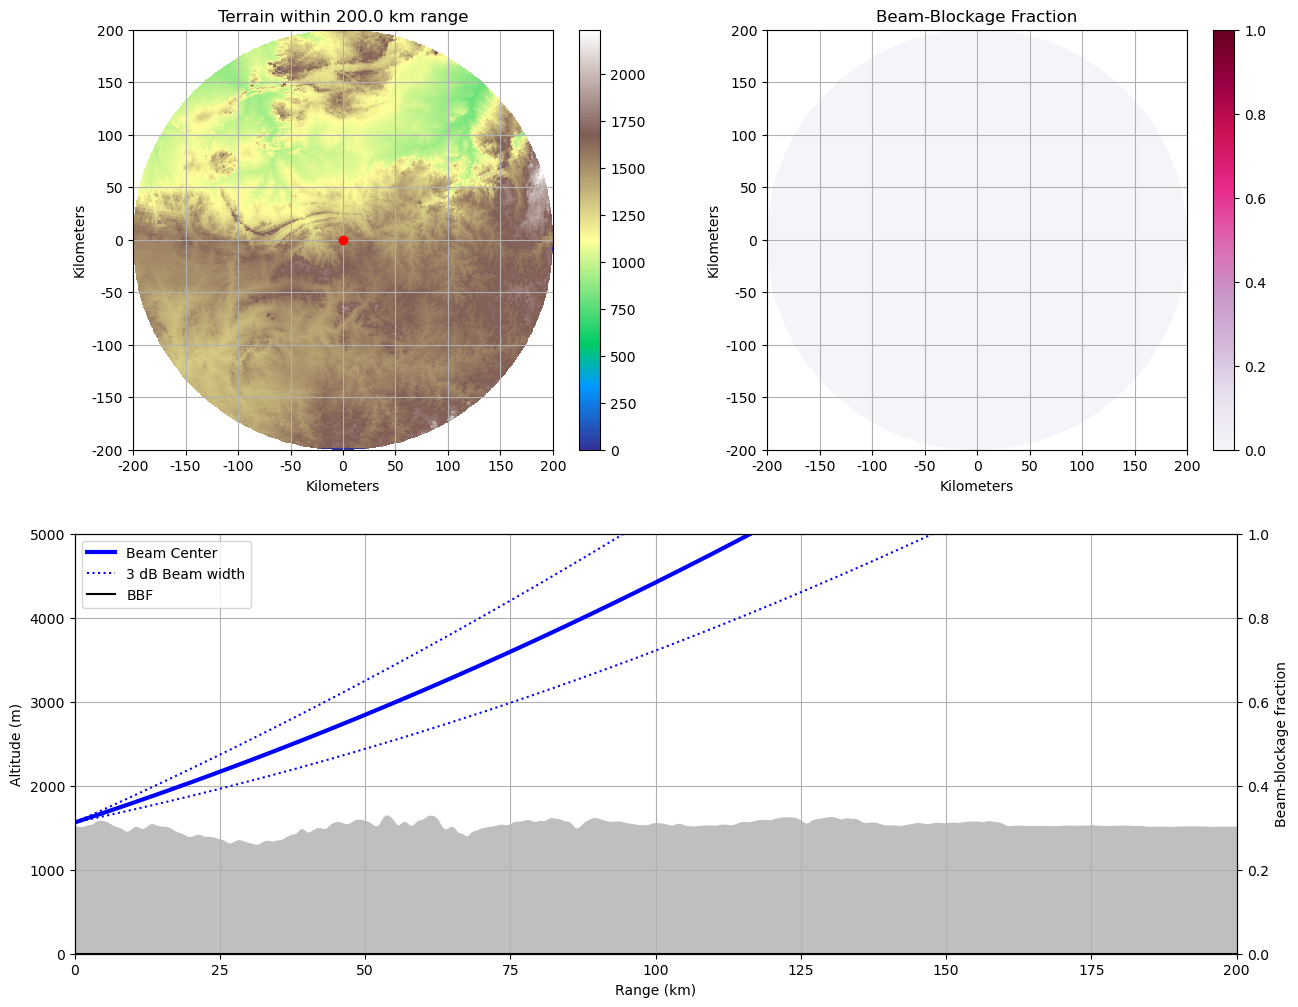

In [47]:
fig = plt.figure(figsize=(15, 12))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 265

# Plot terrain (on ax1)
polarvalues = wrl.georef.create_xarray_dataarray(
    polarvalues, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
dem = polarvalues.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0)
#ax1.plot(
#    [0, np.sin(np.radians(angle)) * 2e5], [0, np.cos(np.radians(angle)) * 2e5], "r-"
#)
ax1.plot(sitecoords[0], sitecoords[1], "ro")
annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) ))

# Plot CBB (on ax2)
CBB = wrl.georef.create_xarray_dataarray(
    CBB, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
cbb = CBB.wrl.vis.plot(ax=ax2, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, "Beam-Blockage Fraction")

# Plot single ray terrain profile on ax3
(bc,) = ax3.plot(r / 1000.0, alt[angle, :], "-b", linewidth=3, label="Beam Center")
(b3db,) = ax3.plot(
    r / 1000.0,
    (alt[angle, :] + beamradius),
    ":b",
    linewidth=1.5,
    label="3 dB Beam width",
)
ax3.plot(r / 1000.0, (alt[angle, :] - beamradius), ":b")
ax3.fill_between(r / 1000.0, 0.0, polarvalues[angle, :], color="0.75")
ax3.set_xlim(0.0, np.max(r / 1000.0) + 0.1)
ax3.set_ylim(0.0, 5000)
ax3.set_xlabel("Range (km)")
ax3.set_ylabel("Altitude (m)")
ax3.grid()

axb = ax3.twinx()
(bbf,) = axb.plot(r / 1000.0, CBB[angle, :], "-k", label="BBF")
axb.set_ylabel("Beam-blockage fraction")
axb.set_ylim(0.0, 1.0)
axb.set_xlim(0.0, np.max(r / 1000.0) + 0.1)


legend = ax3.legend(
    (bc, b3db, bbf),
    ("Beam Center", "3 dB Beam width", "BBF"),
    loc="upper left",
    fontsize=10,
)

In [114]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks() / 1000).astype(int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks() / 1000).astype(int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not title == "":
        ax.set_title(title)
    ax.grid()

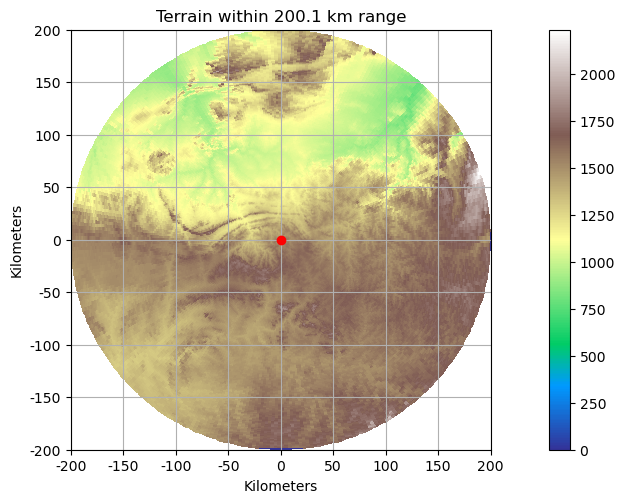

In [115]:
fig = plt.figure(figsize=(15, 12))

# create subplots
ax1 = plt.subplot2grid((2, 1), (0, 0))
#ax2 = plt.subplot2grid((2, 2), (0, 1))
#ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 265

# Plot terrain (on ax1)
polarvalues = wrl.georef.create_xarray_dataarray(
    polarvalues, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
dem = polarvalues.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0, )
#ax1.plot(
#    [0, np.sin(np.radians(angle)) * 2e5], [0, np.cos(np.radians(angle)) * 2e5], "r-"
#)
ax1.plot(sitecoords[0], sitecoords[1], "ro")
annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) + 0.1))

# Plot CBB (on ax2)
CBB = wrl.georef.create_xarray_dataarray(
    CBB, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()



# Publication Map

In [39]:
import rioxarray as rio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

In [102]:
demdata = rio.open_rasterio('gt30e020s10.tif')

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

continent = world[world.continent == 'Africa'].unary_union

country = world.loc[world["iso_a3"] == 'ZAF']

In [99]:
radar = gpd.read_file('../Study/MSc/Data/GIS/Data/Irene_Radar.shp')

radar_range = gpd.read_file('../Study/MSc/Data/GIS/Data/Radar_range_Projected.shp')
radar_range = radar_range.to_crs(radar.crs)

highveld = gpd.read_file('../Study/MSc/Data/GIS/Data/Highveld_outline.shp')
highveld = highveld.to_crs(radar.crs)

In [103]:
demdata = demdata.rio.clip(highveld.geometry)

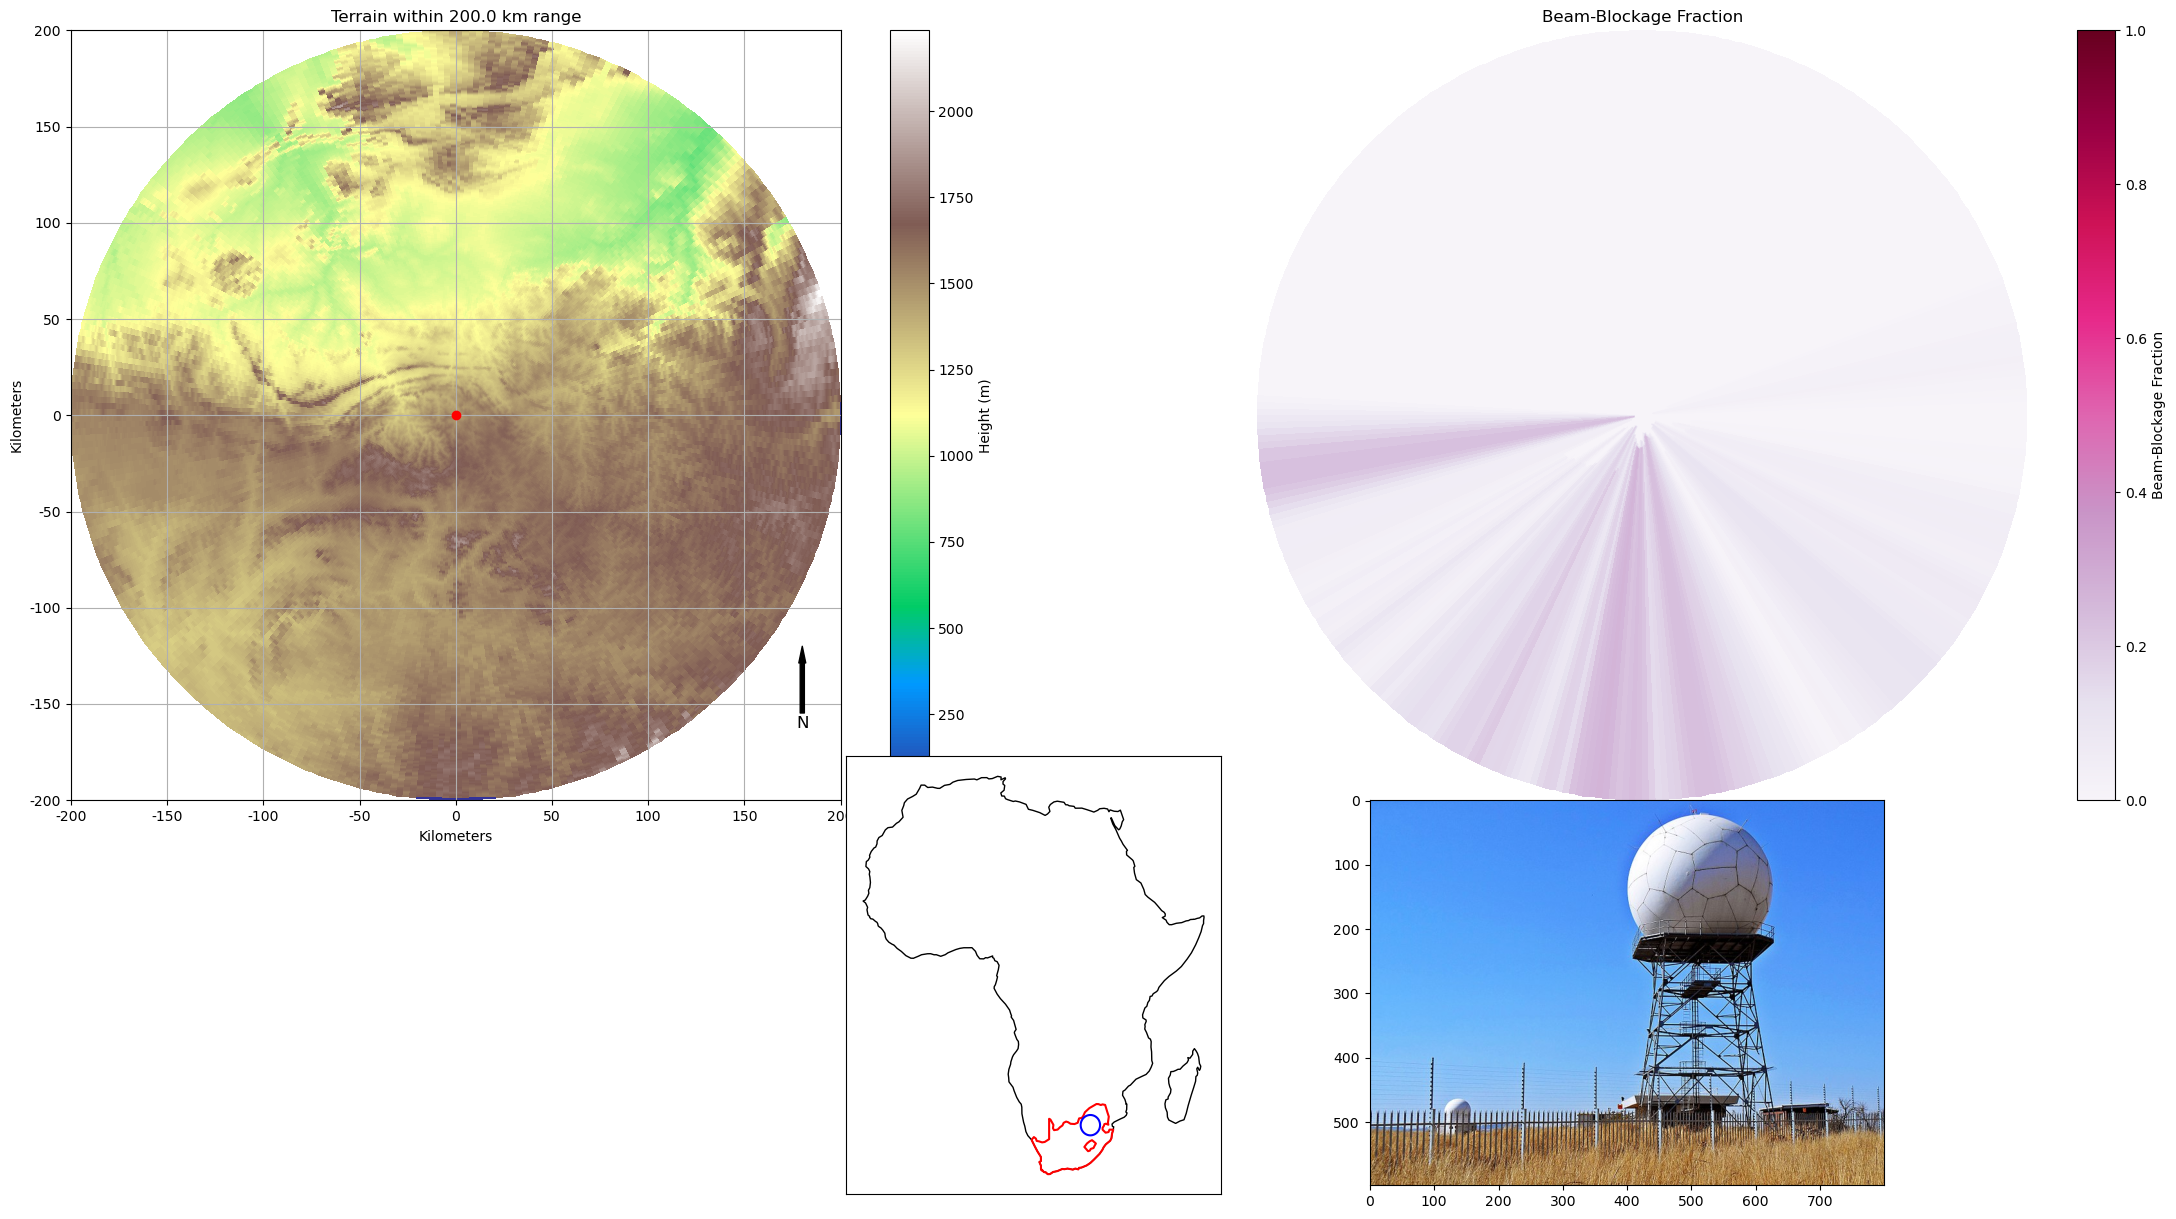

In [237]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=2, left=0.05, right=1.5, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:2, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# azimuth angle
angle = 265

# Plot terrain (on ax1)
polarvalues = wrl.georef.create_xarray_dataarray(
    polarvalues, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
dem = polarvalues.wrl.vis.plot(ax=ax_map, cmap=mpl.cm.terrain, vmin=0.0)

dem.colorbar.set_label('Height (m)')

ax_map.plot(sitecoords[0], sitecoords[1], "ro", label='Irene radar')

annotate_map(ax_map, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) ))

#scalebar = ScaleBar(100, 'km', location='lower left')
#ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)



# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:2,-1])
ax_legend.set_position([0.1, 0.1, 0.8, 0.9])
ax_legend.axis('off')

# Plot CBB (on ax2)
CBB = wrl.georef.create_xarray_dataarray(
    CBB, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
cbb = CBB.wrl.vis.plot(ax=ax_legend, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax_legend, cbb, "Beam-Blockage Fraction")

cbb.colorbar.set_label('Beam-Blockage Fraction')


# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.65, 0.10
                         , 0.25, 0.3])
gpd.GeoDataFrame(geometry=[continent]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country.boundary.plot(ax=ax_minimap, edgecolor='red')
radar_range.boundary.plot(ax=ax_minimap, edgecolor='blue')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap2 = fig.add_subplot(gs[-1, 1])

img = plt.imread('800px-Irene_Weather_Station.jpg')  # Load your image here
ax_minimap2.imshow(img)  # Adjust extent and alpha as needed

#ax_minimap2.set_position([0.80, 0.12, 0.2, 0.3])

#plt.show()
plt.tight_layout()
plt.savefig('radarcoverage_ver2.png', dpi=400)

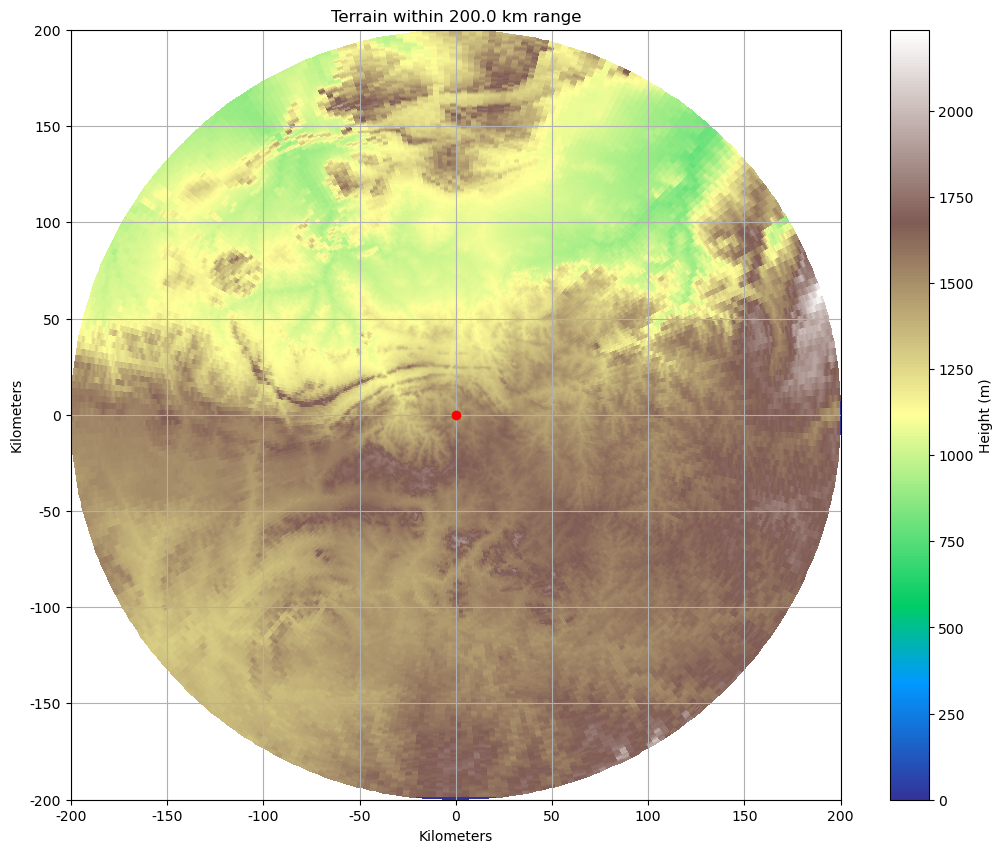

In [239]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=2, left=0.05, right=1.5, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:2, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# azimuth angle
angle = 265

# Plot terrain (on ax1)
polarvalues = wrl.georef.create_xarray_dataarray(
    polarvalues, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
dem = polarvalues.wrl.vis.plot(ax=ax_map, cmap=mpl.cm.terrain, vmin=0.0)

dem.colorbar.set_label('Height (m)')

ax_map.plot(sitecoords[0], sitecoords[1], "ro", label='Irene radar')

annotate_map(ax_map, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) ))

# Save the map plot
plt.tight_layout()
plt.savefig('demmap_plot.png', dpi=400)

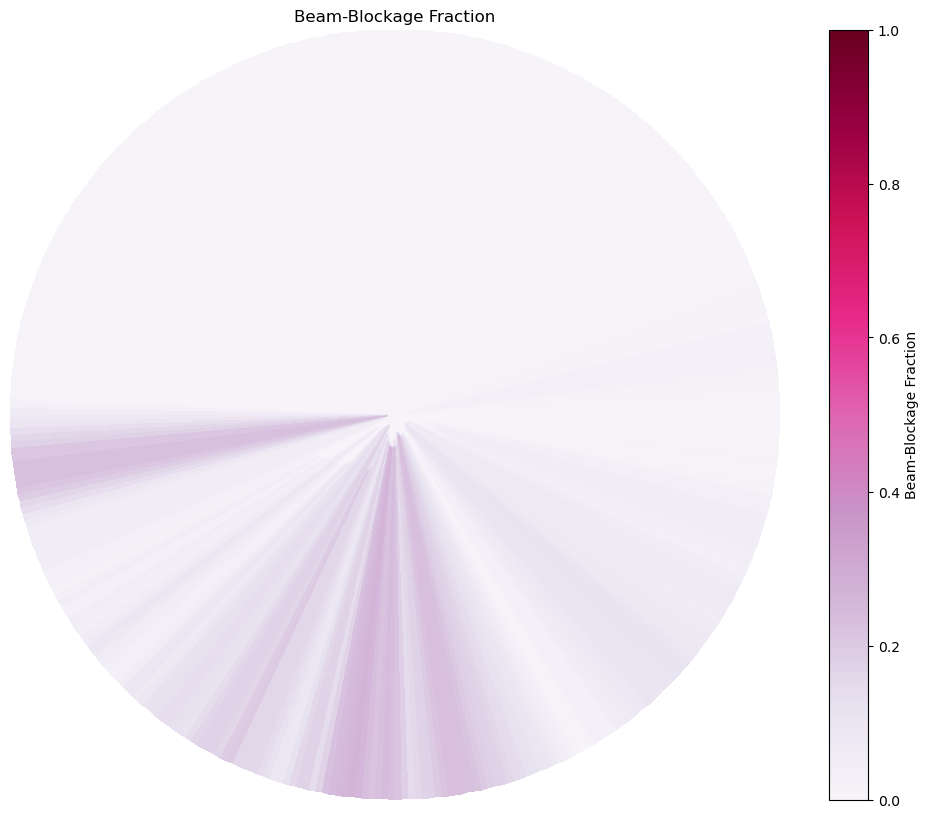

In [248]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=2, left=0.05, right=1.5, hspace=0.0, figure=fig)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:2, -1])
ax_legend.set_position([0.1, 0.1, 0.8, 0.9])
ax_legend.axis('off')

# Plot CBB (on ax2)
CBB = wrl.georef.create_xarray_dataarray(
    CBB, r=r, phi=coord[:, 0, 1]
).wrl.georef.georeference()
cbb = CBB.wrl.vis.plot(ax=ax_legend, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax_legend, cbb, "Beam-Blockage Fraction")

cbb.colorbar.set_label('Beam-Blockage Fraction')

# Save the minimap plot
#plt.tight_layout()
plt.savefig('bbf_plot.png', dpi=400)

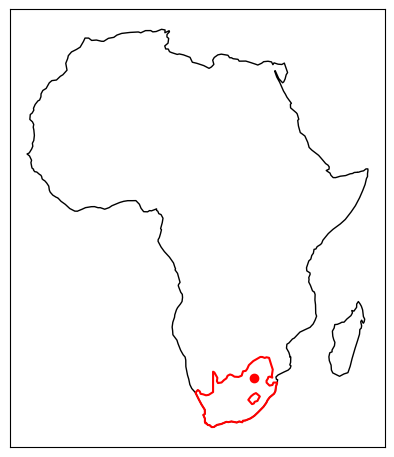

In [255]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=2, left=0.05, right=1.5, hspace=0.0, figure=fig)

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.65, 0.10, 0.25, 0.3])

gpd.GeoDataFrame(geometry=[continent]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country.boundary.plot(ax=ax_minimap, edgecolor='r')
#radar_range.boundary.plot(ax=ax_minimap, edgecolor='blue')
radar.plot(ax=ax_minimap, color='r')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])


# Save the minimap plot
plt.tight_layout()
plt.savefig('minimap_plot.png', dpi=400)

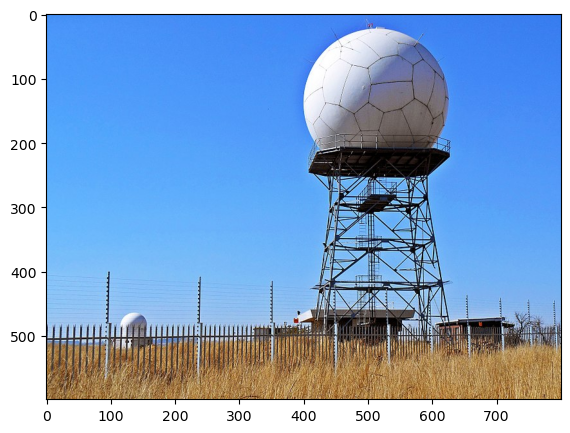

In [247]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=2, left=0.05, right=1.5, hspace=0.0, figure=fig)


# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap2 = fig.add_subplot(gs[-1, 1])

img = plt.imread('800px-Irene_Weather_Station.jpg')  # Load your image here
ax_minimap2.imshow(img)  # Adjust extent and alpha as needed

#ax_minimap2.set_position([0.80, 0.12, 0.2, 0.3])

#plt.show()
plt.tight_layout()
plt.savefig('radarcoverage_ver2.png', dpi=400)